In [1]:
# Dependencies

install.packages(c('readxl', 'qgraph', 'reshape2', 'RColorBrewer'))

Installing packages into ‘/home/sharedvi/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)


In [2]:
# We'll need this for XLSX files:
library(readxl)
rm(list=ls())

Load and additionally preprocess the data:

In [3]:
# Open file
eurovision = data.frame(read_xlsx('Eurovision-Processed.xlsx', ))

# Load everything as factors
eurovision$Year = factor(eurovision$Year, ordered=T)
eurovision$Round = factor(eurovision$Round, ordered=T, levels=c('sf','sf1','sf2','f'))
eurovision$Voters = factor(eurovision$Voters)

#For simplicity replace S&M with Serbia (sorry Montenegro)
eurovision$From_country[eurovision$From_country=='Serbia & Montenegro'] = 'Serbia'
eurovision$To_country[eurovision$To_country=='Serbia & Montenegro'] = 'Serbia'

# Shorten long names so that they fit on diagrams
eurovision$From_country[eurovision$From_country=='Bosnia & Herzegovina'] = 'Bosnia&H.'
eurovision$To_country[eurovision$To_country=='Bosnia & Herzegovina'] = 'Bosnia&H.'

eurovision$From_country[eurovision$From_country=='F.Y.R. Macedonia'] = 'Macedonia'
eurovision$To_country[eurovision$To_country=='F.Y.R. Macedonia'] = 'Macedonia'

eurovision$From_country[eurovision$From_country=='Czech Republic'] = 'Czech R.'
eurovision$To_country[eurovision$To_country=='Czech Republic'] = 'Czech R.'

eurovision$From_country[eurovision$From_country=='United Kingdom'] = 'UK'
eurovision$To_country[eurovision$To_country=='United Kingdom'] = 'UK'

# Factor country names
eurovision$From_country = factor(eurovision$From_country)
eurovision$To_country = factor(eurovision$To_country)

# Discard votes from countries for themselves, they're always 0

eurovision = eurovision[eurovision$From_country != eurovision$To_country, ]

# Discard 2004 semifinal for countries that didn't vote in that:
eurovision = eurovision[eurovision$Year != '2004' | eurovision$Round != 'sf' | !(eurovision$From_country %in% c("France","Poland","Russia")),]

# Look what we got
head(eurovision)


,Year,Round,Voters,From_country,To_country,Points
2,1975,f,J,Belgium,Finland,0
3,1975,f,J,Belgium,France,2
4,1975,f,J,Belgium,Germany,0
5,1975,f,J,Belgium,Ireland,12
6,1975,f,J,Belgium,Israel,1
7,1975,f,J,Belgium,Italy,6


Do some sanity checks

In [4]:
# Sanity check 1: sets of countries in both fields are identical
all(levels(eurovision$From_country) == levels(eurovision$To_country))

[1] TRUE

In [5]:
# Sanity check 2: every country gave away 11 distinct scores
table(aggregate(Points~From_country+Year+Round, data=eurovision, FUN=function(x){length(unique(x))})$Points)


  11 
1670 

In [6]:
# Sanity check 2.5: countries that didn't give away 11 distinct scores
ver_points = aggregate(Points~From_country+Year+Round+Voters, data=eurovision, FUN=function(c){length(unique(c))})
ver_points[ver_points$Points!=11,]

From_country,Year,Round,Voters,Points


In [7]:
# Discard countries that participated in 3 contests or less: 

# List of participations:
participations = aggregate(Year ~ From_country, eurovision, FUN=function(x){length(unique(x))})
participations = participations[order(participations$Year),]
participations

# Excluded list:
exclude = participations$From_country[participations$Year <= 3]
eurovision = eurovision[!(eurovision$From_country %in% exclude | eurovision$To_country %in% exclude),]

,From_country,Year
34,Morocco,1
4,Australia,3
2,Andorra,6
13,Czech R.,6
43,Slovakia,7
32,Monaco,8
41,San Marino,8
33,Montenegro,9
6,Azerbaijan,10
18,Georgia,10


In [8]:
# Re-factor the list after exclusion
eurovision$From_country = factor(eurovision$From_country)
eurovision$To_country = factor(eurovision$To_country)

In [9]:
# Calculate average score for each country in each round:
avg_scores = aggregate(Points ~ To_country+Year+Round+Voters, data=eurovision, mean)

In [10]:
# Calculate biases by substracting average score from votes
biases = eurovision

# This function (signed square of difference) is used to calculate bias:
sigsq <- function(x,y){(x-y)^2*sign(x-y)}

# Calculate bias:
for(i in 1:nrow(biases)) {
    biases$Points[i] = sigsq(biases$Points[i], avg_scores$Points[avg_scores$Year == biases[i, 'Year'] & avg_scores$Round == biases[i, 'Round'] & avg_scores$To_country == biases[i, 'To_country']][1])
}

In [11]:
# Aggregate bias scores over all years and tours:

aggr.bias = aggregate(Points~From_country+To_country, data=biases, FUN=mean)
aggr.bias = aggr.bias[order(aggr.bias$From_country),]

In [12]:
# Look at the most and least biased country pairs

aggr.bias[order(aggr.bias$Points, decreasing = T),]

,From_country,To_country,Points
85,Spain,Andorra,100.36205
1928,Andorra,Spain,98.99650
1460,Serbia,Montenegro,87.94754
26,Macedonia,Albania,81.24176
1370,Romania,Moldova,80.87022
1686,Moldova,Romania,79.59022
481,Greece,Cyprus,76.70039
849,Cyprus,Greece,73.12261
1611,Andorra,Portugal,71.43950
1279,Serbia,Macedonia,70.79639


In [13]:
# Load this for visualisation

library(qgraph)

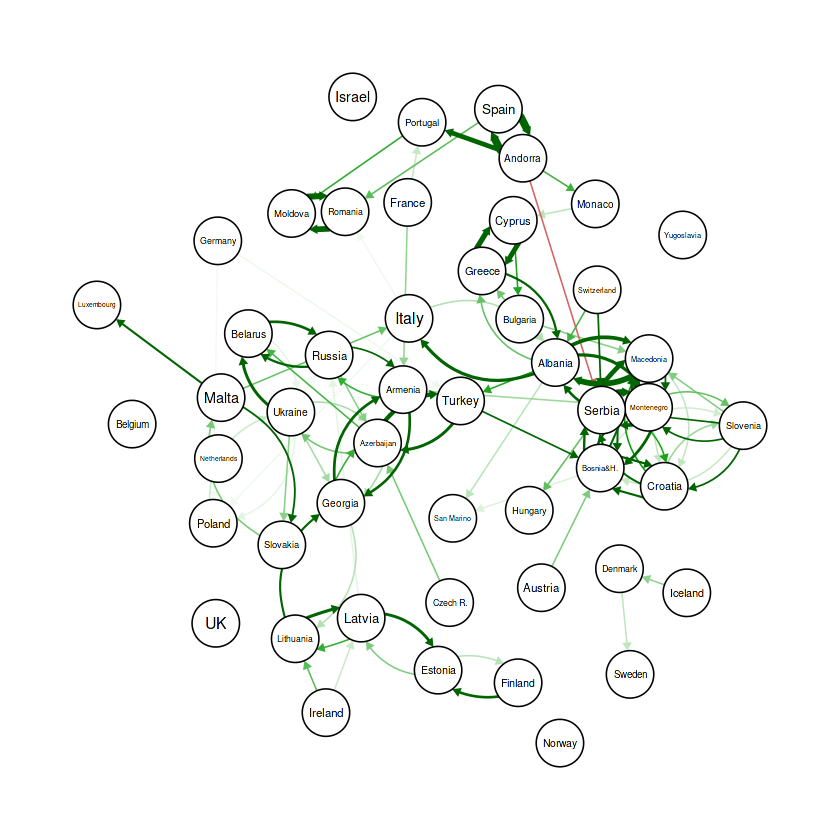

In [14]:
# Plot biases on a weighted directional graph: (uncolored for now)

qgraph(aggr.bias, minimum=25, cut=40)

In [15]:
# This one is needed to convert between long and wide matrices forms

library('reshape2')

In [16]:
# Cast long form to wide form, turn country names into rownames, replace NA's with 0

aggr.distance = dcast(aggr.bias, From_country~To_country)
aggr.distance.matrix = aggr.distance[,-1]
aggr.distance.matrix = as.matrix(aggr.distance.matrix)
rownames(aggr.distance.matrix) = aggr.distance[,1]

aggr.distance.matrix[is.na(aggr.distance.matrix)] = 0

Using Points as value column: use value.var to override.


In [17]:
# To make matrix symmetric, we take the larger (by absolute value) number out of (m,n) and (n,m)

indeces = as.numeric(abs(aggr.distance.matrix)>=abs(t(aggr.distance.matrix)))
aggr.distance.matrix.sym = aggr.distance.matrix*indeces + t(aggr.distance.matrix) * (1-indeces)

In [18]:
# Rescale this matrix so that Largest bias is smallest distance

aggr.distance.matrix.sym = max(aggr.distance.matrix.sym)-aggr.distance.matrix.sym

In [19]:
# Convert to distance matrix

aggr.distance.matrix.sym = as.dist(aggr.distance.matrix.sym)

In [20]:
# Run hierarchical clustering:

clust = hclust(aggr.distance.matrix.sym)

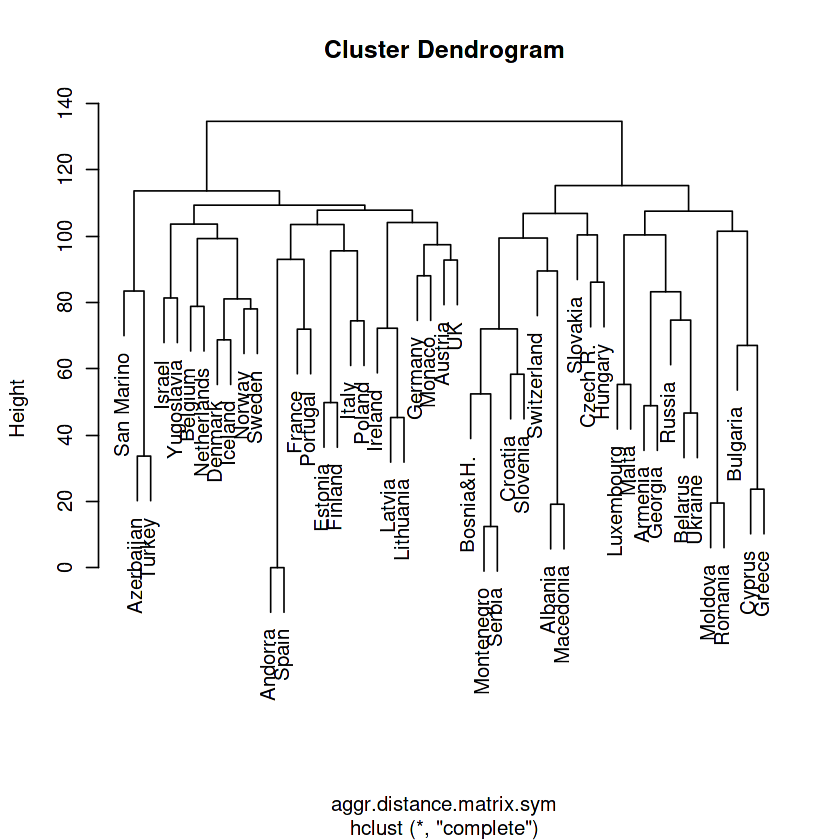

In [21]:
# Show the dendrogram

plot(clust)

In [22]:
# Split into 25 clusters 

cl_groups=cutree(clust, k=25)
cl_groups=cl_groups[clust$order]
cl_groups

# Get grouplist - list of character vectors; each vector represent 1 cluster
grlist = list()
i=1
for(j in unique(cl_groups)) {
    countries = names(cl_groups)[cl_groups==j]
    countries = factor(countries, levels = levels(eurovision$From_country))
    grlist[[i]] = countries
    i=i+1
}

# Remove groups with 1 item

grlist2 = grlist[lapply(grlist,length) > 1]
grlist2

San Marino  Azerbaijan      Turkey      Israel  Yugoslavia     Belgium 
         22           5           5          17          17           7 
Netherlands     Denmark     Iceland      Norway      Sweden     Andorra 
          7          11          11          11          11           2 
      Spain      France    Portugal     Estonia     Finland       Italy 
          2          13          13          12          12          18 
     Poland     Ireland      Latvia   Lithuania     Germany      Monaco 
         18          16          16          16          14          21 
    Austria          UK   Bosnia&H.  Montenegro      Serbia     Croatia 
          4          25           8           8           8           8 
   Slovenia Switzerland     Albania   Macedonia    Slovakia    Czech R. 
          8          24           1           1          23          10 
    Hungary  Luxembourg       Malta     Armenia     Georgia      Russia 
         15          19          19           3           3           6 
    Belarus     Ukraine     Moldova     Romania    Bulgaria      Cyprus 
          6           6          20          20           9           9 
     Greece 
          9

[[1]]
[1] Azerbaijan Turkey    
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[2]]
[1] Israel     Yugoslavia
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[3]]
[1] Belgium     Netherlands
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[4]]
[1] Denmark Iceland Norway  Sweden 
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[5]]
[1] Andorra Spain  
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[6]]
[1] France   Portugal
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[7]]
[1] Estonia Finland
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[8]]
[1] Italy  Poland
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[9]]
[1] Ireland   Latvia    Lithuania
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[10]]
[1] Bosnia&H.  Montenegro Serbia     Croatia    Slovenia  
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[11]]
[1] Albania   Macedonia
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[12]]
[1] Luxembourg Malta     
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[13]]
[1] Armenia Georgia
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[14]]
[1] Russia  Belarus Ukraine
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[15]]
[1] Moldova Romania
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

[[16]]
[1] Bulgaria Cyprus   Greece  
49 Levels: Albania Andorra Armenia Austria Azerbaijan Belarus ... Yugoslavia

In [23]:
# Remove countries which are alone in a cluster

loners = unlist(grlist[lapply(grlist,length) == 1])
aggr.bias.clust = aggr.bias[!(aggr.bias$From_country %in% loners | aggr.bias$To_country %in% loners),]
aggr.bias.clust$From_country = factor(aggr.bias.clust$From_country)
aggr.bias.clust$To_country = factor(aggr.bias.clust$To_country)

# Re-factorize the list
grlist2 = lapply(grlist2, function(c) {c = factor(c,levels = levels(aggr.bias.clust$From_country))})

Now, visualizations!

In [24]:
# Need this for the color palette
library(RColorBrewer)

In [25]:
# A palette of background colors for graph circles

my_pal=c(brewer.pal(9,"Pastel1"), brewer.pal(8,"Pastel2"), brewer.pal(12, "Paired")[c(1,3,5,7,9,11)], brewer.pal(6,"Set2")[c(5,6)])

In [26]:
# A pallette of foreground colors for the dendrogram

my_pal2=c(brewer.pal(12,"Paired")[c(2,4,6,8,10,12)], brewer.pal(8,"Dark2"), brewer.pal(5,"Set1"), brewer.pal(8,"Accent")[5:8],brewer.pal(10,"RdGy")[c(2,10)])

png 
  2

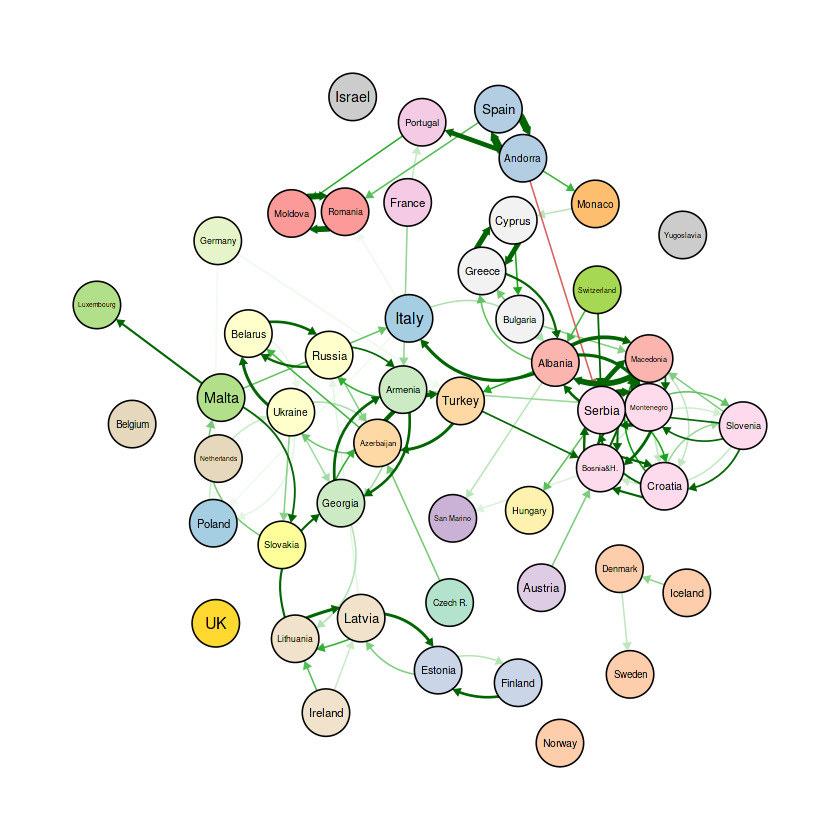

In [27]:
# Re-draw our unclustered graph with colors

qgraph(aggr.bias, minimum=25, cut=40, color=my_pal[cl_groups][order(names(cl_groups))])

postscript("unclustered.eps", width = 6, height = 6, horizontal = FALSE, onefile = FALSE)
qgraph(aggr.bias, minimum=25, cut=40, color=my_pal[cl_groups][order(names(cl_groups))])
dev.off()

png 
  2

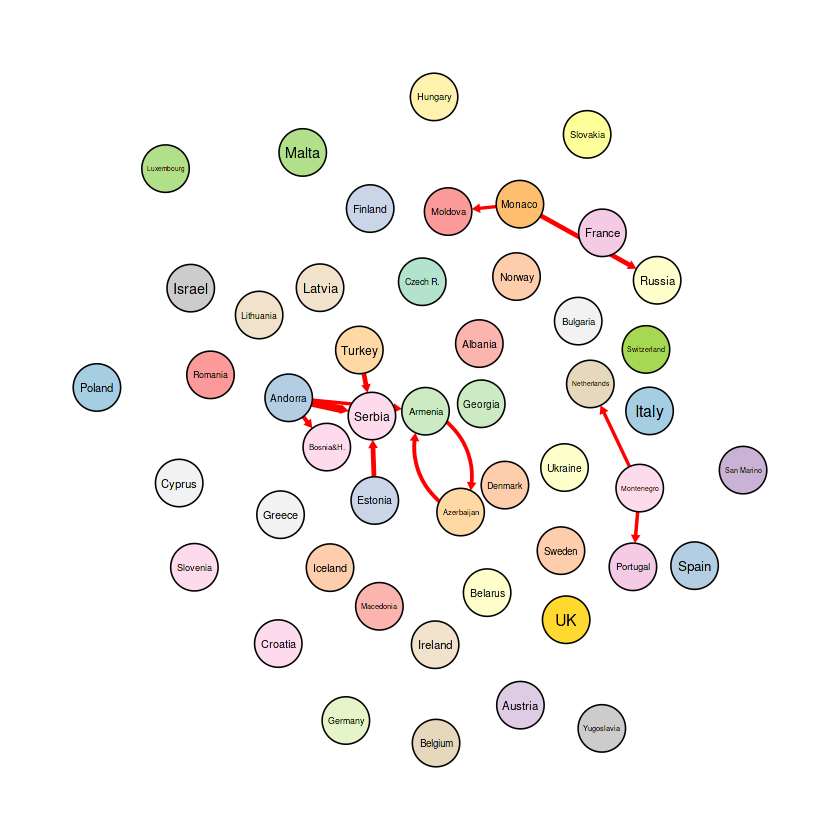

In [28]:
# Unclustered graph with colors for negative items only

qgraph(aggr.bias[aggr.bias$Points<0,], minimum=15, color=my_pal[cl_groups][order(names(cl_groups))])

postscript("unclusteredNeg.eps", width = 6, height = 6, horizontal = FALSE, onefile = FALSE)
qgraph(aggr.bias[aggr.bias$Points<0,], minimum=15, color=my_pal[cl_groups][order(names(cl_groups))])
dev.off()

png 
  2

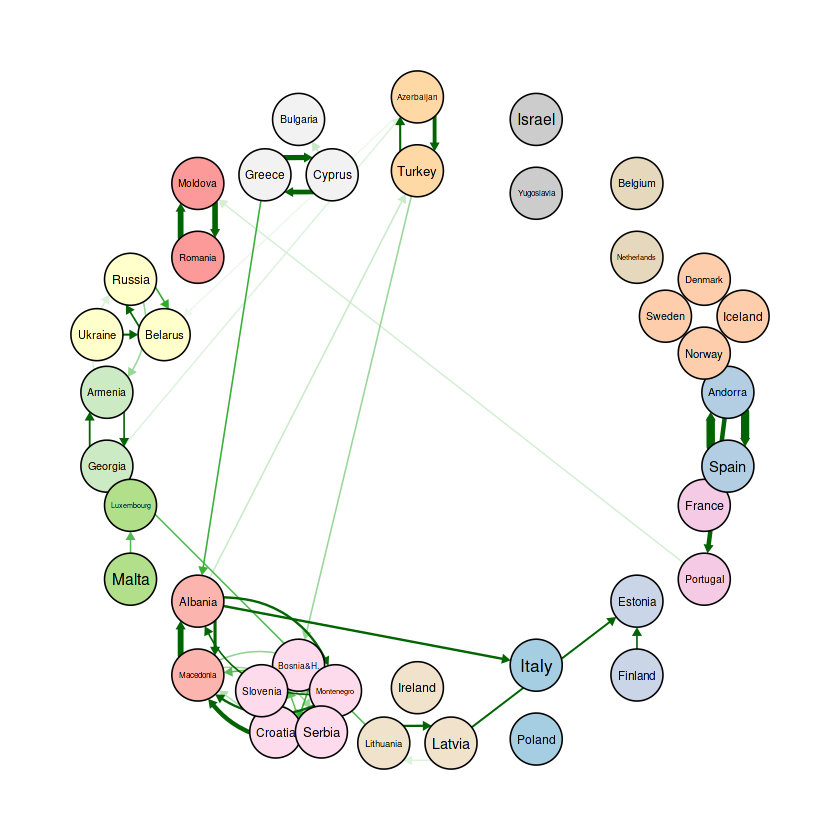

In [29]:
# Draw a clustered graphs (customly rearranged palette)

qgraph(aggr.bias.clust, layout='groups', groups=grlist2, minimum=35, cut=50, color=my_pal[c(5,17,7,11,2,13,12,18,16,8,1,19,3,6,20,9)])

postscript("clustered.eps", width = 6, height = 6, horizontal = FALSE, onefile = FALSE)
qgraph(aggr.bias.clust, layout='groups', groups=grlist2, minimum=35, cut=50, color=my_pal[c(5,17,7,11,2,13,12,18,16,8,1,19,3,6,20,9)])
dev.off()

In [30]:
# Export clusters into CSV file for map visualisation
cl_groups2  = cl_groups[!names(cl_groups) %in% loners]
ccc = sapply(cl_groups2, function(x){which.max(unique(cl_groups2)==x)})
write.csv(cbind(names(ccc),unname(ccc)), 'cl.csv')

In [31]:
# Count number of wins

a1 = aggregate(Points~To_country+Year+Voters, eurovision, subset = Round=="f", sum)
a2 = aggregate(Points~To_country+Year, a1, mean)
a3 = aggregate(Points~Year, a1, which.max)

winners = c()
for (y in a3$Year) {
    aa4 = a2[a2$Year == y,]
    winners = c(winners, as.character(aa4$To_country[which.max(aa4$Points)]))
}
winners = table(winners)
winners

winners
    Austria  Azerbaijan     Belgium     Denmark     Estonia     Finland 
          1           1           1           2           1           1 
     France     Germany      Greece     Ireland      Israel       Italy 
          2           2           1           6           3           1 
     Latvia  Luxembourg Netherlands      Norway    Portugal      Russia 
          1           1           1           3           1           1 
     Serbia      Sweden Switzerland      Turkey          UK     Ukraine 
          1           4           1           1           3           2 
 Yugoslavia 
          1 

In [32]:
# Extend wins with 0

winners[levels(eurovision$To_country)[!levels(eurovision$To_country) %in% names(winners)]]=0
winners=winners[order(names(winners))]

In [33]:
# For dendrogram fan layout

suppressPackageStartupMessages(library(ape))

In [34]:
# For circle

library(plotrix)

png 
  2

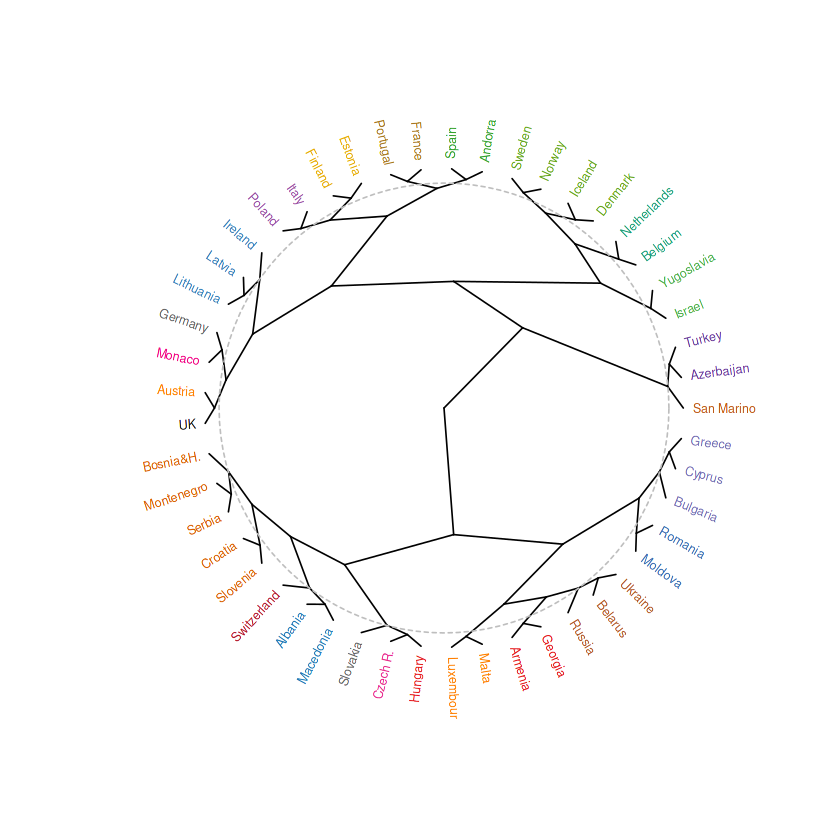

In [35]:
# Plot dendrogram with circular layout, draw the level circle

plot(as.phylo(clust), type = "radial",  tip.color =  my_pal2[cl_groups][order(names(cl_groups))], label.offset=0.04, cex=0.6)
draw.circle(0,0,0.94, border = 'gray', lty='dashed')

postscript("printsPerfectly.eps", width = 6, height = 6, horizontal = FALSE, onefile = FALSE)
plot(as.phylo(clust), type = "radial",  tip.color =  my_pal2[cl_groups][order(names(cl_groups))], label.offset=0.04, cex=0.6)
draw.circle(0,0,0.94, border = 'gray', lty='dashed')
dev.off()    
    

In [36]:
# Re-sort bias to analyse how mutual the arrows are

aggr.bias.2 = aggr.bias[order(aggr.bias$To_country),]
head(aggr.bias.2,20)

From_country,To_country,Points
Andorra,Albania,-2.4968906
Armenia,Albania,-1.9974329
Austria,Albania,7.6983172
Azerbaijan,Albania,0.5321833
Belarus,Albania,-5.3390520
Belgium,Albania,5.4738469
Bosnia&H.,Albania,5.9029563
Bulgaria,Albania,-1.8414504
Croatia,Albania,19.0443762
Cyprus,Albania,-4.1637952


In [37]:
# Here, two mutual bias scores between the countries are geometrically averaged:

ab3 = aggr.bias
ab3$Points = sign(aggr.bias$Points * aggr.bias.2$Points) * sqrt(abs(aggr.bias$Points * aggr.bias.2$Points))
ab3 = ab3[order(ab3$Points, decreasing = T),]
head(ab3)
tail(ab3)

,From_country,To_country,Points
1928,Andorra,Spain,99.67693
85,Spain,Andorra,99.67693
1242,Albania,Macedonia,70.61806
227,Turkey,Azerbaijan,59.88452
1911,Montenegro,Slovenia,54.75479
1686,Moldova,Romania,54.58501


,From_country,To_country,Points
119,Monaco,Armenia,-22.78478
2075,Azerbaijan,Turkey,-23.81112
124,Portugal,Armenia,-25.72876
529,Greece,Czech R.,-26.24580
1279,Serbia,Macedonia,-31.67890
1460,Serbia,Montenegro,-33.45848


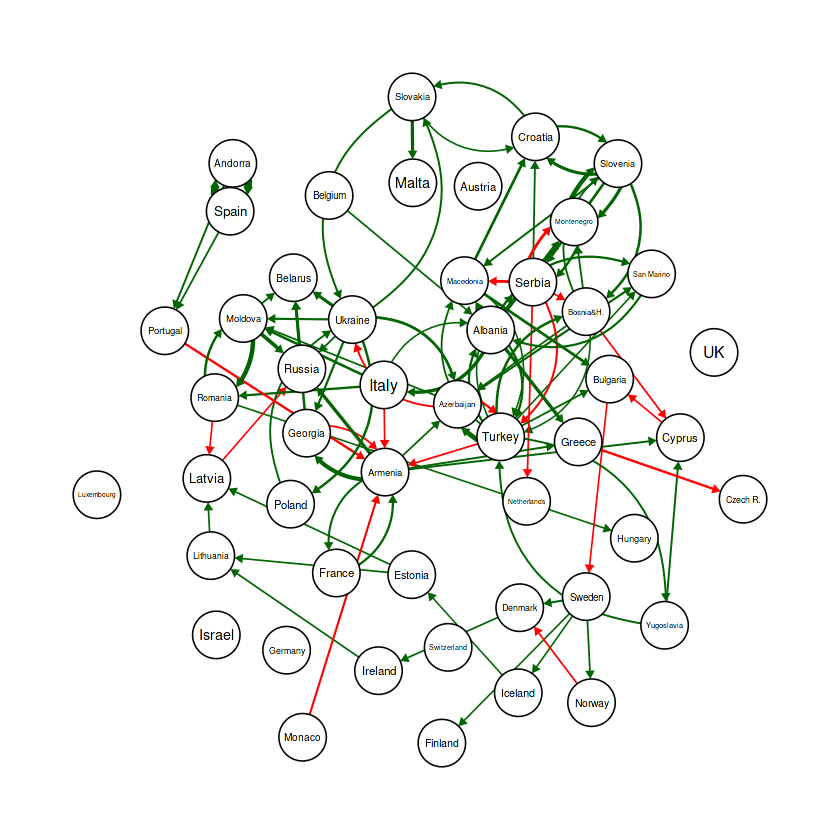

In [38]:
# Plot graph of the bias symmetricity:

qgraph(ab3, minimum=15)

# Something didn't work as expected...

In [39]:
# Who is Estonia biased towards:

estb = aggr.bias[aggr.bias$From_country=="Estonia",]
estb[order(estb$Points, decreasing = T),]

,From_country,To_country,Points
1137,Estonia,Latvia,32.5545744
663,Estonia,Finland,29.1778962
1717,Estonia,Russia,23.2028222
1988,Estonia,Sweden,16.8565226
2036,Estonia,Switzerland,11.5616235
1529,Estonia,Norway,8.6534081
759,Estonia,Georgia,7.9781957
900,Estonia,Hungary,6.4901383
946,Estonia,Iceland,6.4338352
568,Estonia,Denmark,5.7420918


In [40]:
# By years: 1975-1984

aggr.bias.84 = aggregate(Points~From_country+To_country, data=biases, FUN=mean, subset = (Year >= 1975 & Year < 1985))
aggr.bias.84 = aggr.bias.84[order(aggr.bias.84$From_country),]

In [41]:
# By years: 1985-1994

aggr.bias.94 = aggregate(Points~From_country+To_country, data=biases, FUN=mean, subset = (Year >= 1985 & Year < 1995))
aggr.bias.94 = aggr.bias.94[order(aggr.bias.94$From_country),]

In [42]:
# By years: 1995-2004

aggr.bias.04 = aggregate(Points~From_country+To_country, data=biases, FUN=mean, subset = (Year >= 1995 & Year < 2005))
aggr.bias.04 = aggr.bias.04[order(aggr.bias.04$From_country),]

In [43]:
# By years: 2005-2017

aggr.bias.17 = aggregate(Points~From_country+To_country, data=biases, FUN=mean, subset = (Year >= 2005))
aggr.bias.17 = aggr.bias.17[order(aggr.bias.17$From_country),]

In [44]:
# Plot all of these:

png 
  2

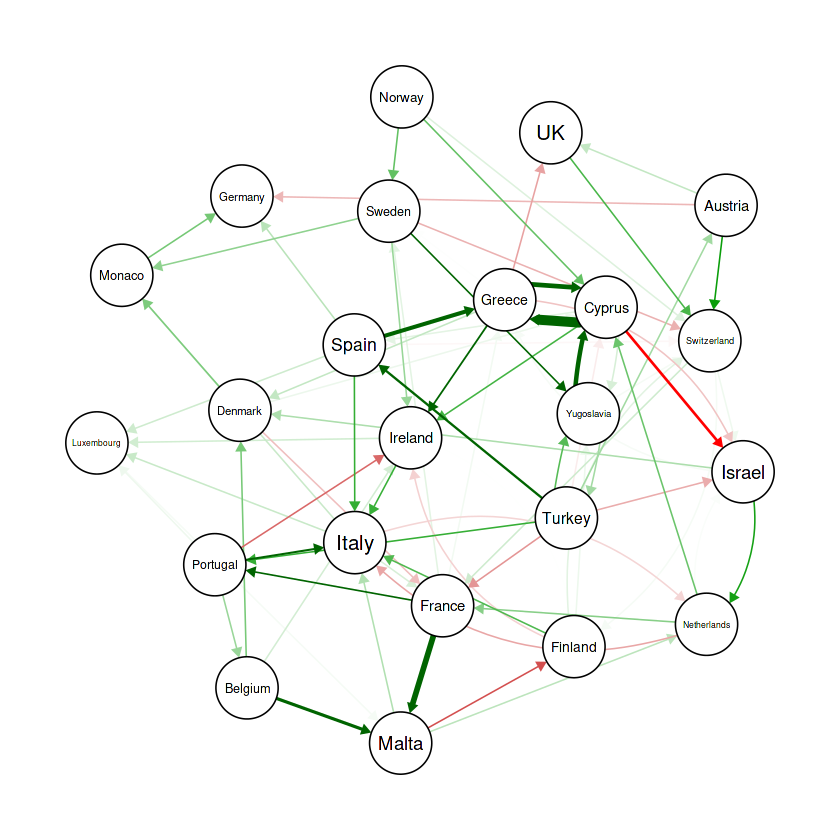

In [45]:
qgraph(aggr.bias.84, minimum=10, cut=20)

postscript("84.eps", width = 6, height = 6, horizontal = FALSE, onefile = FALSE)
qgraph(aggr.bias.84, minimum=10, cut=20)
dev.off()

png 
  2

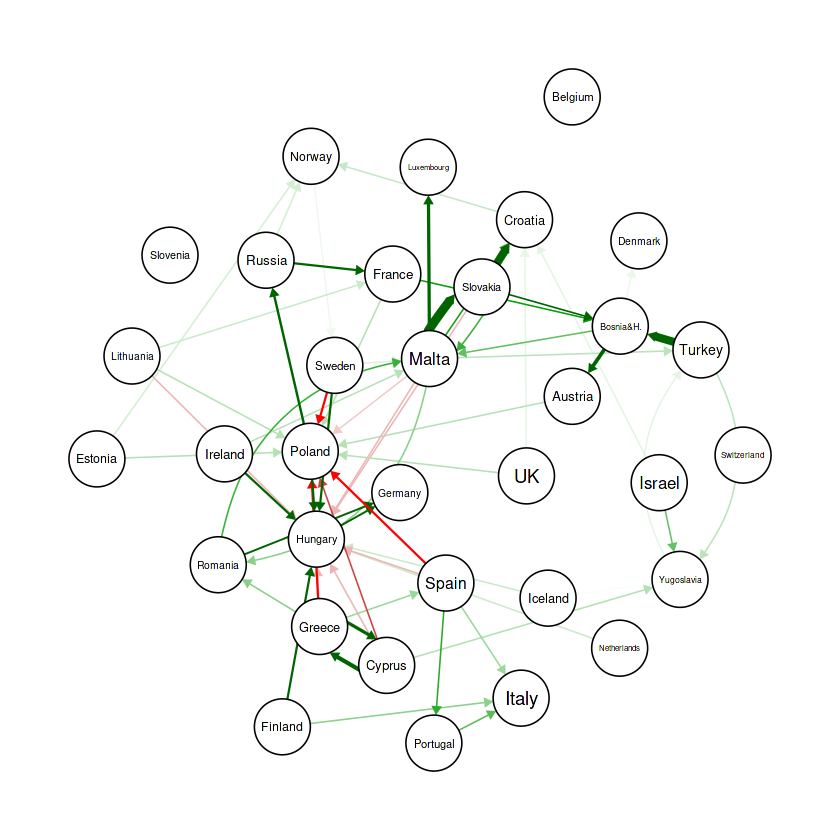

In [46]:
qgraph(aggr.bias.94, minimum=20, cut=40)

postscript("94.eps", width = 6, height = 6, horizontal = FALSE, onefile = FALSE)
qgraph(aggr.bias.94, minimum=20, cut=40)
dev.off()

png 
  2

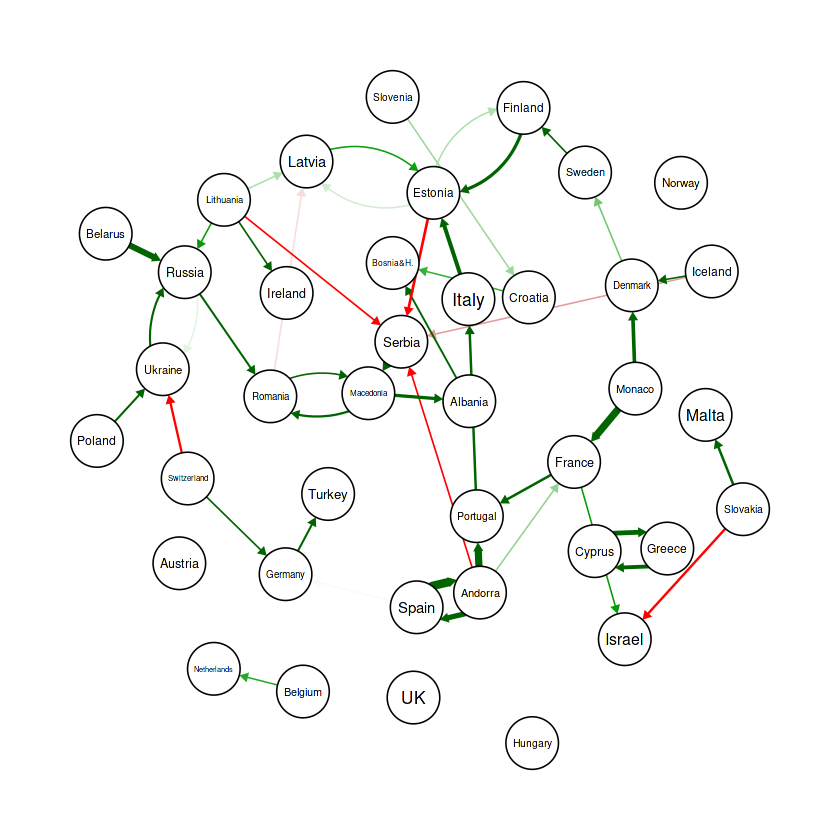

In [47]:
qgraph(aggr.bias.04, minimum=30, cut=40)

postscript("04.eps", width = 6, height = 6, horizontal = FALSE, onefile = FALSE)
qgraph(aggr.bias.04, minimum=30, cut=40)
dev.off()

png 
  2

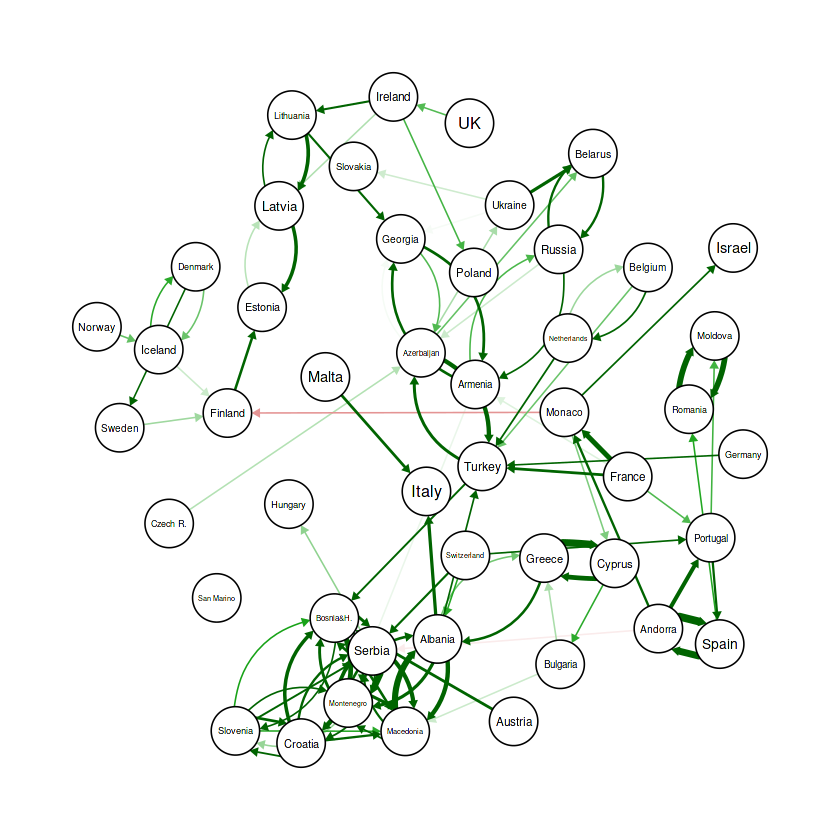

In [48]:
qgraph(aggr.bias.17, minimum=30, cut=40)

postscript("17.eps", width = 6, height = 6, horizontal = FALSE, onefile = FALSE)
qgraph(aggr.bias.17, minimum=30, cut=40)
dev.off()